## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os 
import preprocessingV1
import visualization
from utils import generate_signal_dictionary
path = os.getcwd()

## DATA PREPROCESSING

We read all the data, split them into 2 subsets of training and testing data. 

In [2]:
import random
from random import sample
# ========================================================================
signal_16zt = preprocessingV1.get_filename('16zt')
signal_8zt = preprocessingV1.get_filename('8zt')
signal_0zt = preprocessingV1.get_filename('0zt')

random.seed(10)

# 16zt =====================================================================
test_idx_16zt = sample(range(1,len(signal_16zt)),4)
# train_idx_16zt = sample(range(1,len(signal_16zt)),8)
train_idx_16zt = list(set(np.arange(0,len(signal_16zt)))-set(test_idx_16zt))
# 8zt =====================================================================
test_idx_8zt = sample(range(1,len(signal_8zt)),4)
# train_idx_8zt = sample(range(1,len(signal_16zt)),8)
train_idx_8zt = list(set(np.arange(0,len(signal_8zt)))-set(test_idx_8zt))
# 0zt =====================================================================
test_idx_0zt = sample(range(1,len(signal_0zt)),4)
# train_idx_0zt = sample(range(1,len(signal_16zt)),8)
train_idx_0zt = list(set(np.arange(0,len(signal_0zt)))-set(test_idx_0zt))

name_dict = {'16zt': (signal_16zt[train_idx_16zt], signal_16zt[test_idx_16zt]),
             '8zt': (signal_8zt[train_idx_8zt], signal_8zt[test_idx_8zt]),
             '0zt': (signal_0zt[train_idx_0zt], signal_0zt[test_idx_0zt])}

In [3]:
data = {}; data_test = {}
name = ['0zt','8zt','16zt']
for n in name:
    data, data_test = generate_signal_dictionary(data, data_test,outlier_filter=True, name_dict = name_dict, name=n)

## Reading and preprocessing data

I reckon that there are many unusual peaks in the signals, so I decided to filter out the values which are outside of [Q1-1.5IQR,Q3+1.5IQR] (i.e., the usual statistical definition for outliers). 

Next, I perform 4 scaling strategies on the signals: None, by MinMax, by mean and std, and partially by mean and std. The last option will consider each waveform individually before scaling instead of scaling the whole signals.

In [4]:
window_size = 1024

df, label = preprocessingV1.generate_model_data(data_dictionary=data,mode = 'cnn2d',scale = None,window_size = window_size,verbose = True,hop_length=1024)
df_test, label_test = preprocessingV1.generate_model_data(data_dictionary=data_test,mode = 'cnn2d',scale = None,window_size = window_size,verbose = True,hop_length=1024)

X = df, label
y = df_test, label_test

Mode: cnn2d
Scale option: None
Model data shape: (186392, 65, 65), label shape: (186392,)
Class distribution:  (array([0, 1, 2, 3, 4, 5, 6]), array([  9766,  21571,   7368, 105315,  13839,  23385,   5148],
      dtype=int64))
Class encoding:  {'np': 0, 'c': 1, 'e1': 2, 'e2': 3, 'f': 4, 'pd': 5, 'g': 6}
Mode: cnn2d
Scale option: None
Model data shape: (39098, 65, 65), label shape: (39098,)
Class distribution:  (array([0, 1, 2, 3, 4, 5, 6]), array([ 3160,  5151,  1762, 16454,  5778,  5523,  1270], dtype=int64))
Class encoding:  {'np': 0, 'c': 1, 'e1': 2, 'e2': 3, 'f': 4, 'pd': 5, 'g': 6}


In [5]:
from models import CNN2D
from DataGeneratorV0 import get_loader
import implementV0

In [6]:
device = 'cuda'

num_epochs = 50
learning_rate = 0.0001

CNN_scale_trainloss = {}
CNN_scale_validationacc = {}
CNN_scale_classaccuracy = {}
CNN_scale_testscore = {}
CNN_scale_testcf = {}

scale = [None]
for s in scale:
    print(f'================ Scale strategy: {s} ================')
    train_loader, validation_loader, test_loader = get_loader(X,y,mode = 'cnn2d')
    # Call model
    model = CNN2D().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

    train_loss = []
    validation_accuracy = []
    class_accuracy = []
    test_score = []
    test_confusion_matrix = []

    # Train
    for epoch in range(num_epochs):
        
        implementV0.train_one_epoch(model,device,optimizer,criterion,train_loader,train_loss)
        implementV0.validate_one_epoch(model,device,validation_loader,validation_accuracy)

        if (epoch %10 == 0) or (epoch == num_epochs - 1):
            print(f'Epoch [{epoch+1}/{num_epochs}] - loss: {train_loss[epoch]:.4f} - validation accuracy: {validation_accuracy[epoch]:.2f}')  

    implementV0.test(model,device,label_test,test_loader,test_score,class_accuracy,test_confusion_matrix)
    
    CNN_scale_trainloss[s] = train_loss
    CNN_scale_validationacc[s]  = validation_accuracy
    CNN_scale_classaccuracy[s]  = class_accuracy
    CNN_scale_testscore[s]  = test_score
    CNN_scale_testcf[s]  = test_confusion_matrix
    

# m = CNN2D()
# m.load_state_dict(torch.load('CNN2D state_dict checkpoint.pth'))

================ Scale strategy: None ================
Train, validate, test lengths: (130474, 55918, 39098)
Input shape: torch.Size([32, 1, 65, 65])
Epoch [1/50] - loss: 0.4448 - validation accuracy: 0.90
Epoch [11/50] - loss: 0.1377 - validation accuracy: 0.93
Epoch [21/50] - loss: 0.0905 - validation accuracy: 0.94
Epoch [31/50] - loss: 0.0683 - validation accuracy: 0.93
Epoch [41/50] - loss: 0.0578 - validation accuracy: 0.93
Epoch [50/50] - loss: 0.0508 - validation accuracy: 0.93
Accuracy : 0.9164
Balanced accuracy: 0.8882
Predicted labels: (array([0, 1, 2, 3, 4, 5, 6], dtype=int64), array([ 3235,  4207,  1620, 16466,  5618,  6544,  1408], dtype=int64))
True labels: (array([0, 1, 2, 3, 4, 5, 6]), array([ 3160,  5151,  1762, 16454,  5778,  5523,  1270], dtype=int64))



In [10]:
torch.save(model.state_dict(),'CNN2D state_dict checkpoint.pth')

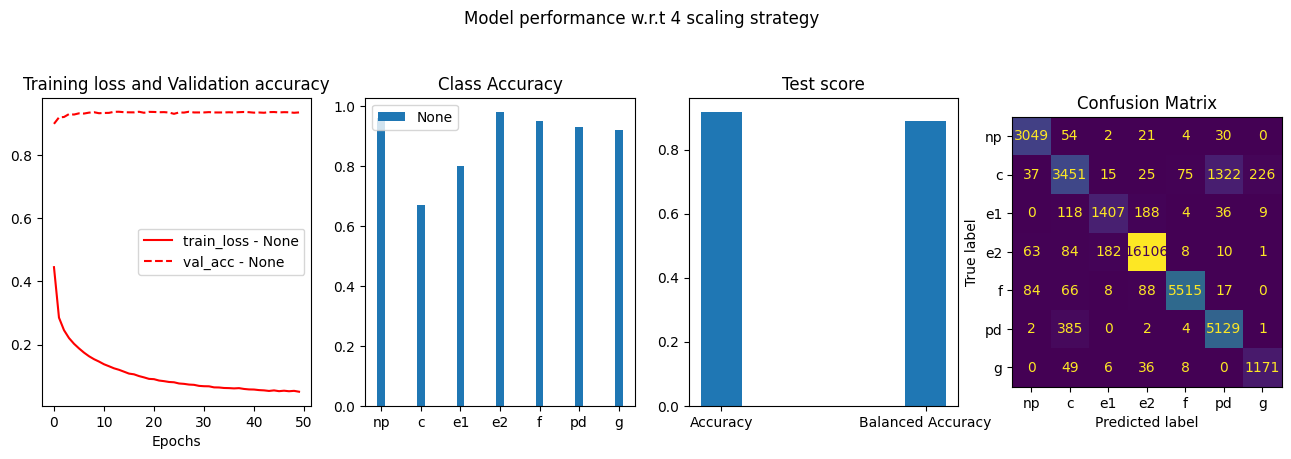

In [7]:
implementV0.plot_test_result(scale,CNN_scale_trainloss, CNN_scale_validationacc, CNN_scale_classaccuracy, CNN_scale_testscore, CNN_scale_testcf)

In [8]:
import matplotlib.pyplot as plt

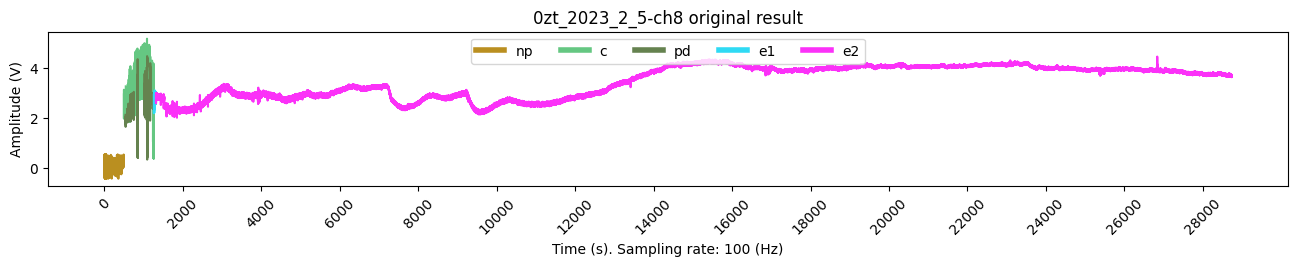

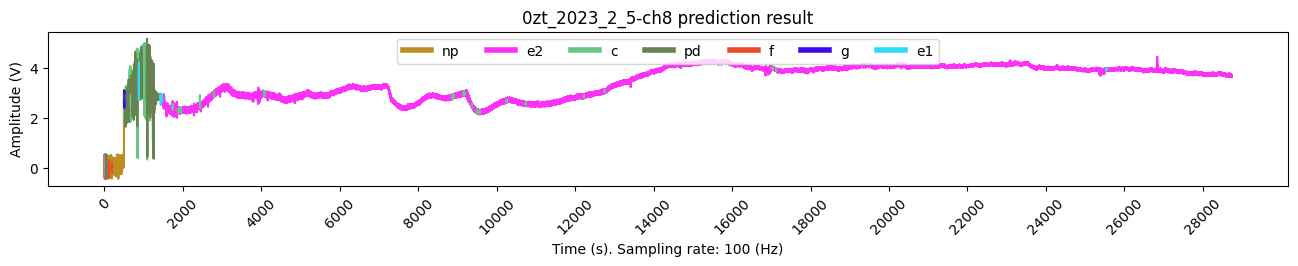

In [9]:
file = name_dict['0zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

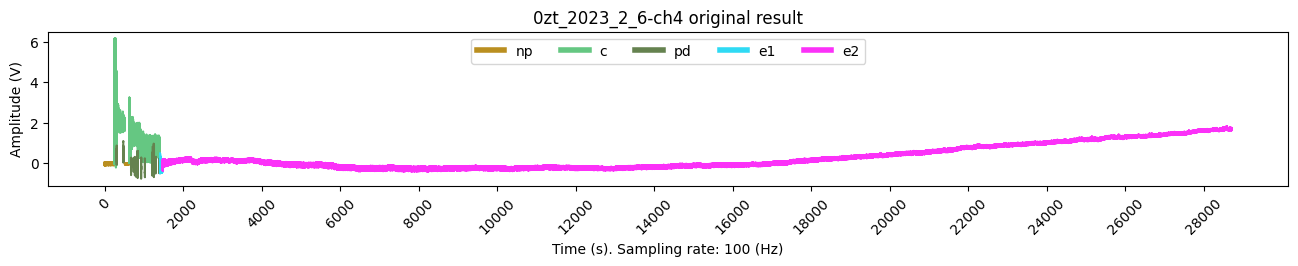

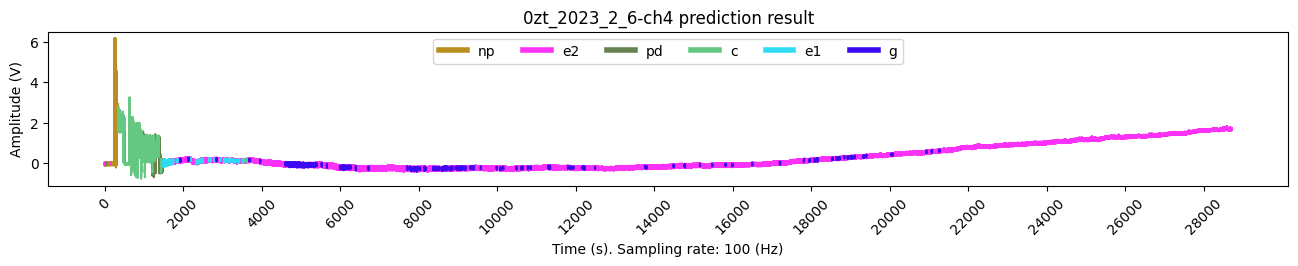

In [17]:
file = name_dict['0zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

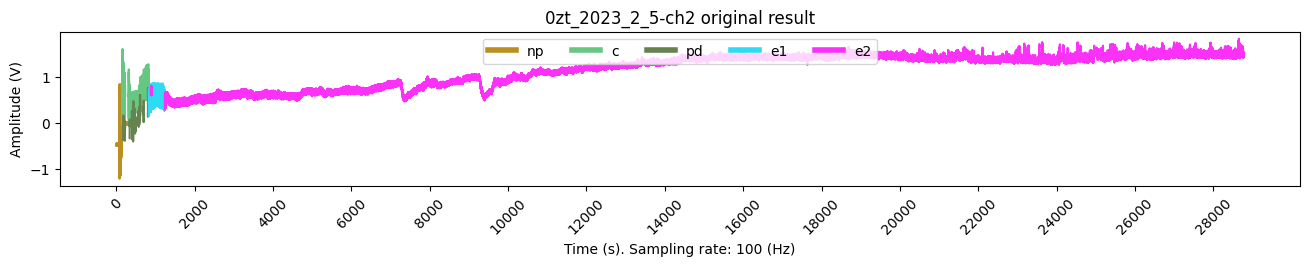

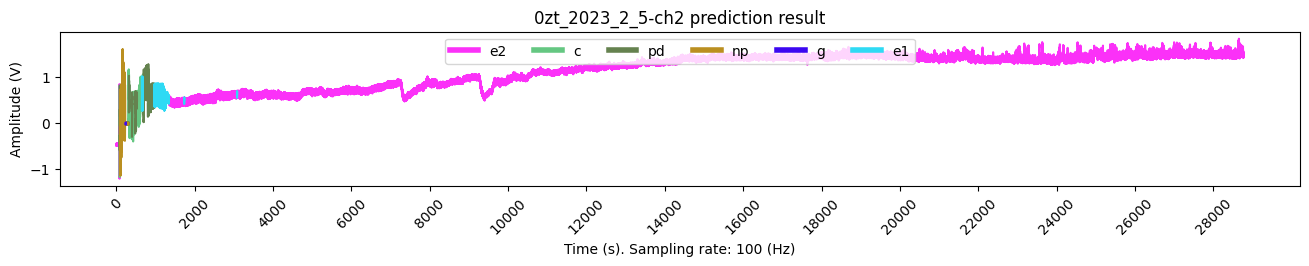

In [18]:
file = name_dict['0zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

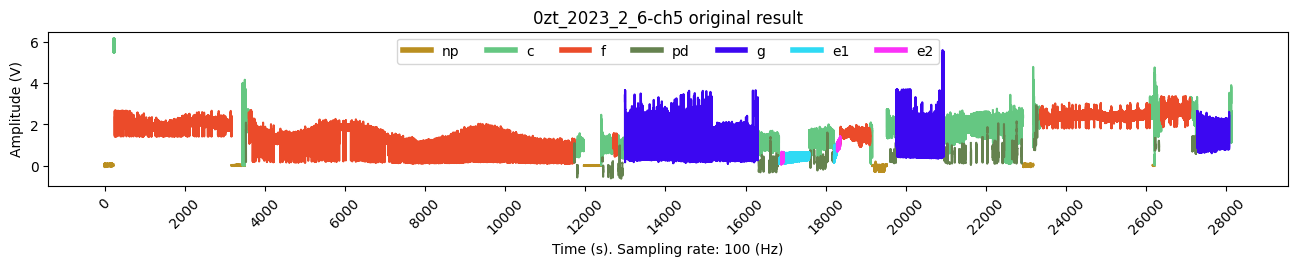

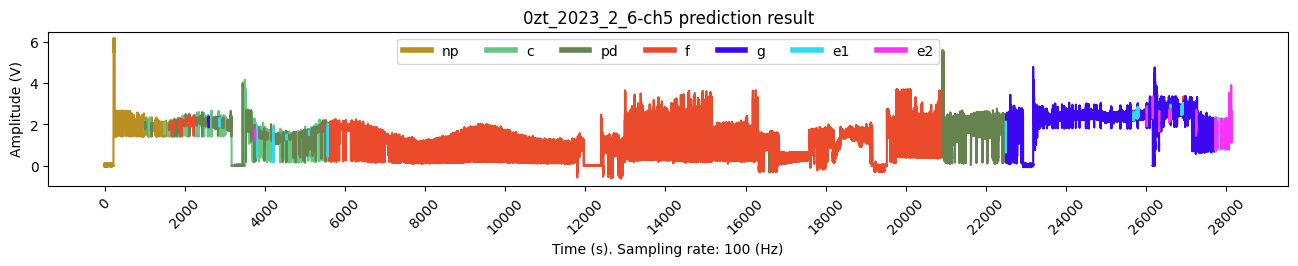

In [11]:
file = name_dict['0zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

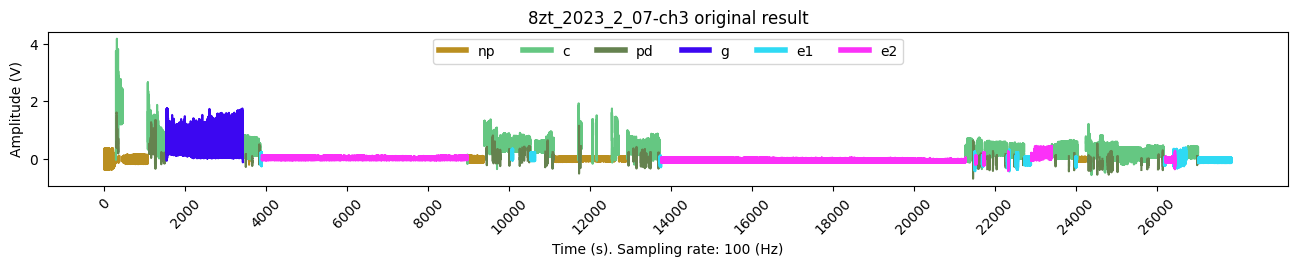

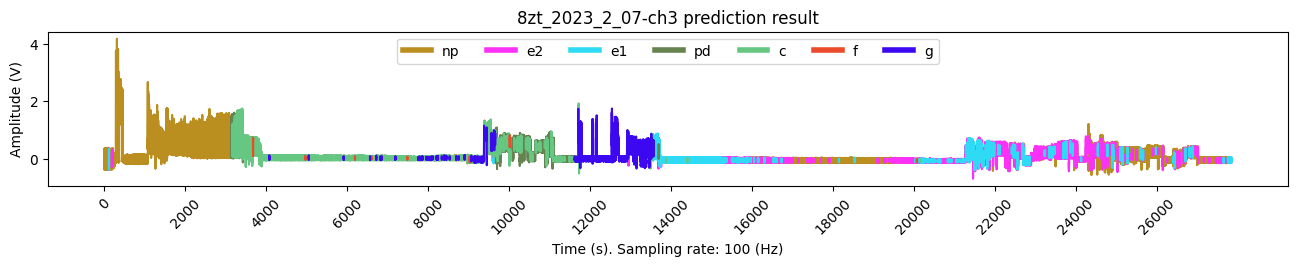

In [19]:
file = name_dict['8zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

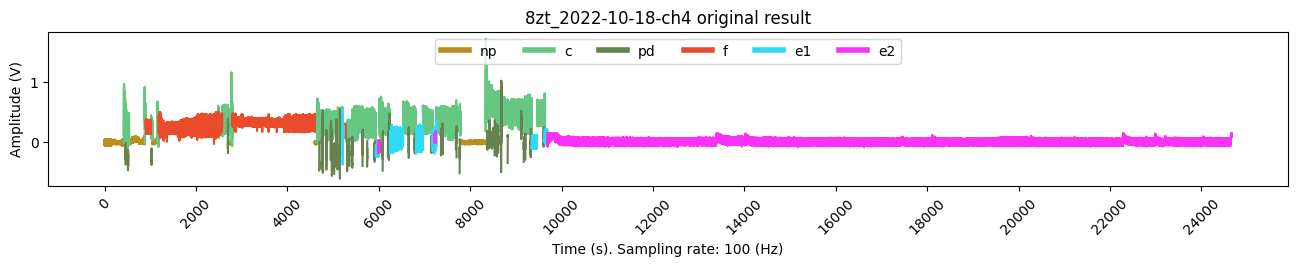

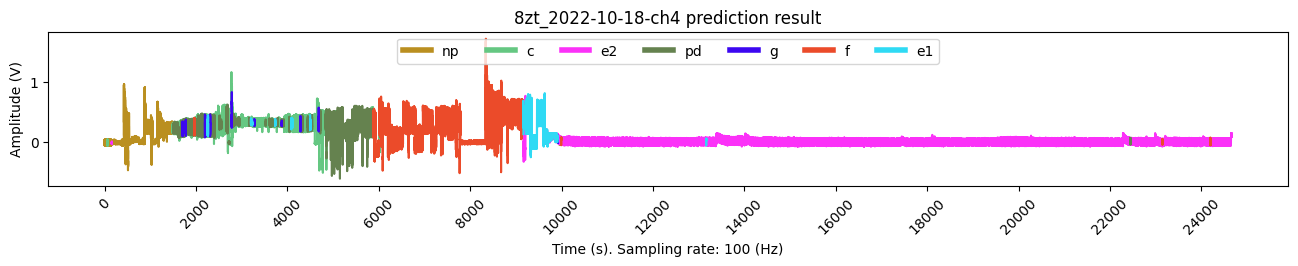

In [20]:
file = name_dict['8zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

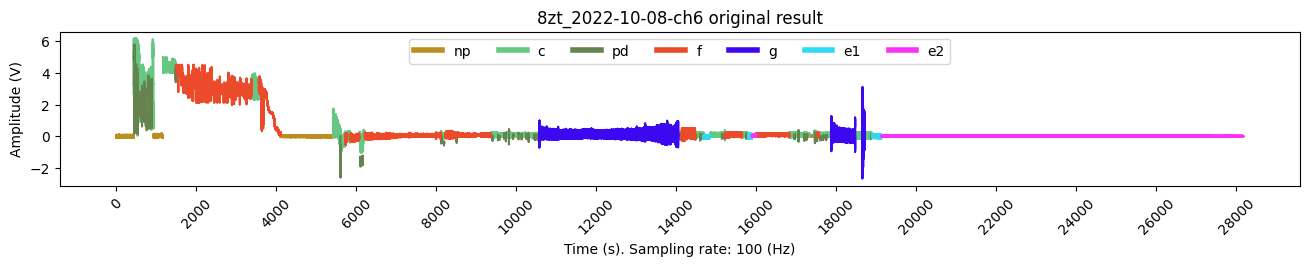

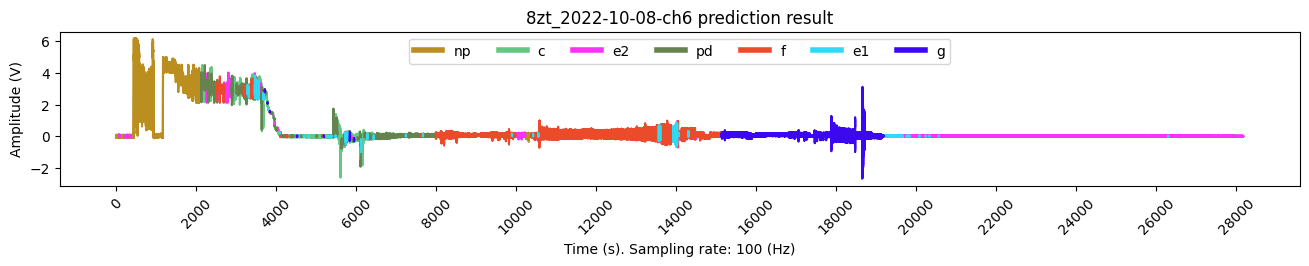

In [21]:
file = name_dict['8zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

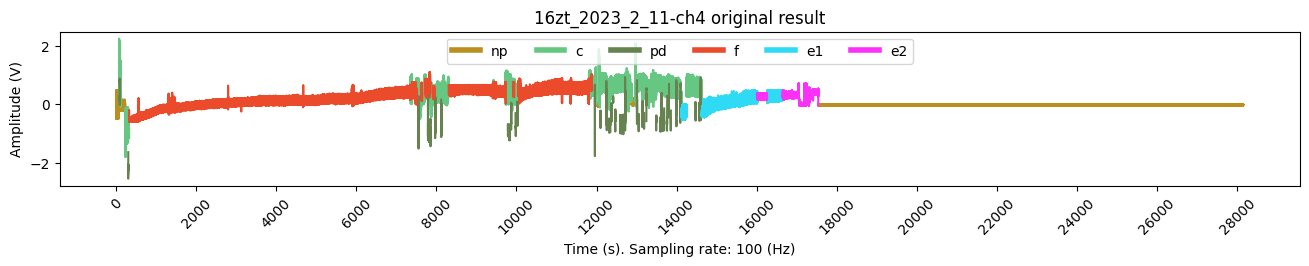

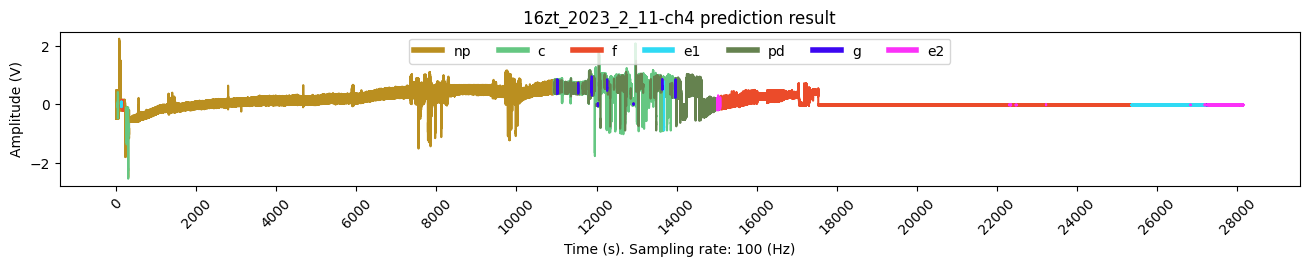

In [22]:
file = name_dict['16zt'][1][0]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

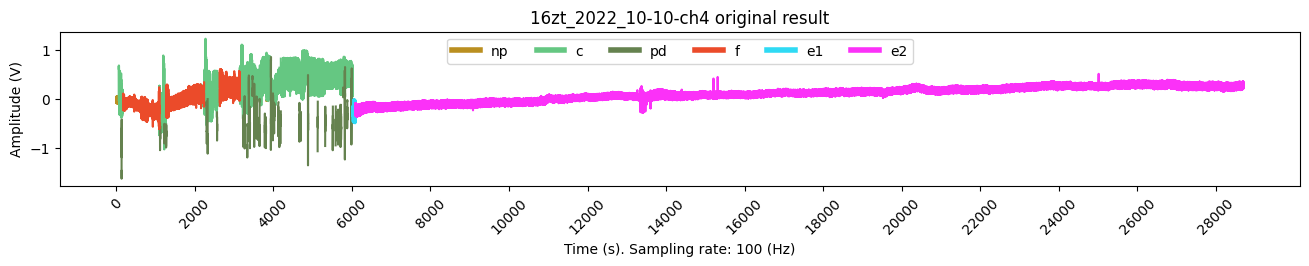

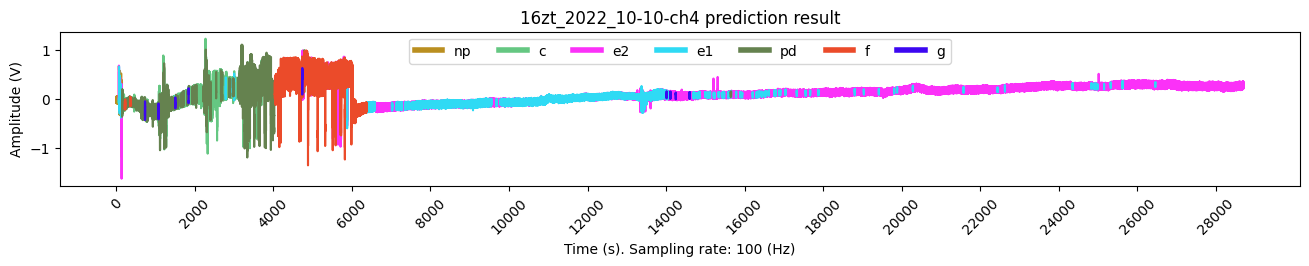

In [23]:
file = name_dict['16zt'][1][1]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

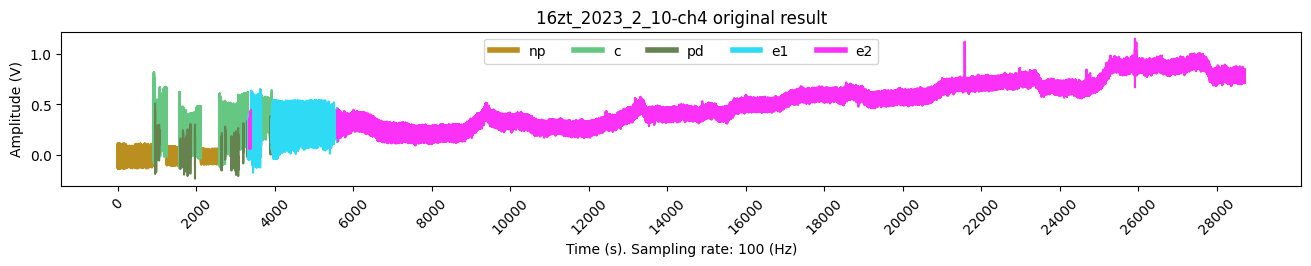

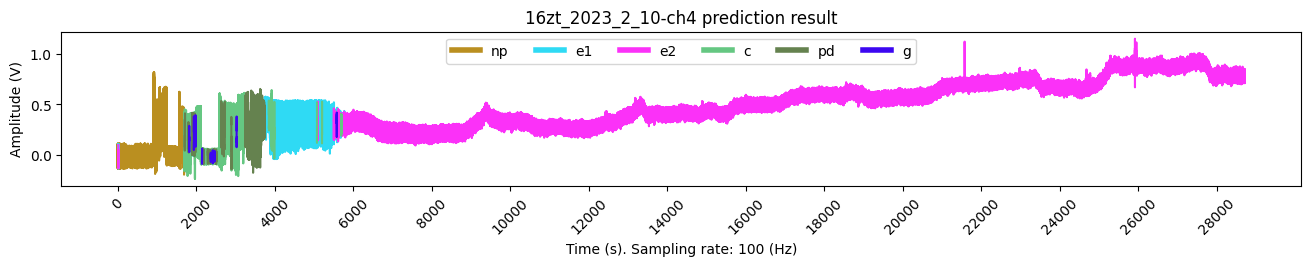

In [24]:
file = name_dict['16zt'][1][2]
wave_array,ana = data_test[file]

model.eval()
pred_ana = implementV0.make_prediction(wave_array,ana,model,device,mode = 'cnn2d')
pred_ana['time'] = pred_ana['time'].apply(lambda x: x*100).astype(int)

# pred_ana.to_csv(f'predicted_ana_{filename_test[0]}.ANA',sep = '\t',header = None,index=None)

visualization.visualize_wave(wave_array,ana)
plt.title(f'{file} original result')
visualization.visualize_wave(wave_array,pred_ana)
plt.title(f'{file} prediction result')
plt.show()

# Final comment

Our model use direct fft coefficients as input and it has given pretty promising results.

However, there are many further things to improve

- Data augmentation: We could try to oversample the short and minor class such as 'pd' to emphasizes this behavior
- There are noises in the signals that has to be considered, for example: 'np' waves should looks like a flat line but there are instances that 'np' waves amplitudes fluctuate arond 1V
- Our model has not taken into account the relation between waveforms. For example, you can only find 'pd' waves in between pathway 'c' waves, or 'e1' is usually followed up by 'e2', ...